In [1]:
%pip install pandas 
%pip install python-dotenv
%pip install -U scikit-learn
%pip install sun_position_calculator
%pip install requests
%pip install docxtpl
%pip install matplotlib
%pip install tabulate
%pip install pyxirr
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#local models
from typing import Dict
from models.econometrics import Cost, Currency
from models.components import Component
from models.econometrics import Cost
from models.geometry import Orientation
from models.photovoltaic import Photovoltaic


#init project
from models.components import Tech
from models.consumption import Energetic
from models.inventory import Building, Project
import pandas as pd

In [3]:
#local env variables
from dotenv import dotenv_values
config = dotenv_values(".env.local")

# Building references

## Address and general info🌎

In [4]:
#cspell:disable


project:Project = Project(
    title='Sistema Fotovoltaico OnGrid-Mixto',
    building = Building(
        geolocation=(-32.42445147637287,-70.91363775132959,0),
        name='PSR Sector La Viña',
        address='Ruta E455, Sector La Viña,\nCabildo',
        city='Cabildo'),
    technology= [Tech.PHOTOVOLTAIC],
    consumption= {
        'description':'main',
        'energetic':Energetic.ELI,
        'cost_increment':7/100,
        'consumption':[
            (372,"06-04-2023",58329),
            (438,"06-05-2023",68470),
            (1040,"06-06-2023",199212),
            (1343,"07-07-2023",261400),
            (1010,"07-08-2023",156169),
            (937,"06-09-2023",144962),
            (806,"07-10-2023",124851),
            (599,"08-11-2023",93072),
            (538,"07-12-2023",84791),
            (452,"08-01-2024",72079),
            (452,"08-01-2024",72079),
            (632,"07-02-2024",105514),
            (474,"07-03-2024",81999),
            
            ],
        }
    )

getting weather data...
api request URL https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M&community=RE&latitude=-32.42445147637287&longitude=-70.91363775132959&start=20230101&end=20231231&format=JSON
getting currencies data...
set $1 Peso Chileno... on USD$0.00 
set $1 UF............. on USD$40.78 
set $1 UTM............ on USD$71.55 
set $1 Euro........... on USD$1.09 
set $1 Pound.......... on USD$1.30 
set $1 Real........... on USD$0.18 
adding consumptions data...


# Integration 

## Machine Components 🎡

In [5]:
#cspell: disable
from libs.repository import repo

#clean previous load
project.components = {}
from IPython.display import clear_output

from models.energy_storage import Battery
from models.photovoltaic import Length, PvTechnicalSheet
clear_output(wait=True)

# assembly projects components
project.add_component(
    'generación',
    Photovoltaic(project.weather,'Módulo FV A',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel PV 655W 48V',
                quantity=12,
                cost=Cost(248171/1.19,Currency.CLP),
                orientation=Orientation(15,-77.61),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    generator=True
    )

project.add_component(
    'auxiliar',
    repo['inverter']['Solis 8kW'],#inverter
    Component('Controlador de Carga',
                model='Enertik 80A 12/24V',
                specification='1000W to 2000 24V output',
                cost_per_unit=Cost(101600,Currency.CLP)),
    Component('medidor bidireccional',
                model='Elster AS1440',
                specification='Trifasico',
                cost_per_unit=Cost(306990,Currency.CLP)),
    Battery('almacenamiento',
                model='MP GEL12-250',
                reference='https://www.tiendatecnored.cl/bateria-gel-ciclo-profundo-12v-250ah.html',
                cost_per_unit=Cost(305990,Currency.CLP),
                volt=12,
                charge=250,
                demand=project.building.consumption_forecast(['main'])['energy'].to_list(),
                hours_autonomy=5,#hours,
                use_regime='16/7'
                )
    )

project.add_component(
    'obras',
    Component(description='instalación eléctrica',
            specification='H/P eléctrico',
            cost_per_unit=Cost(1,currency=Currency.UF),
            quantity=12*5,
            ),
    Component(description='estructura de soporte',
            specification='elementos fijación',
            cost_per_unit=Cost((4*800+11400/4+4*700+4000+500)),
            quantity=12*4
            )
)


inside cost pv :  208547.05882352943 Currency.CLP


# Write Document 📒


In [6]:
import os
PATH = 'build/'+f'r_{project.building.city.lower()[:3]}_{project.building.name}/'

if not os.path.exists(PATH):
    #create
    os.makedirs(PATH)

### Saving results on EXCEL ❎

In [7]:
from models.plotter import toTable
toTable(project,PATH)

### Generate Context->Doc📄✍️

In [8]:
from docxtpl import DocxTemplate # type: ignore
#init doc
#assembly proxy object 
memory_report = DocxTemplate("templates/memory_template.docx")
bidding_report = DocxTemplate("templates/bidding_template.docx")

## Write params and tables

In [9]:
#loading context
#cspell: disable
memory_report.render(project.context(template=memory_report))
bidding_report.render(project.context(template=bidding_report))


## Insert Plots 📊

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot_done


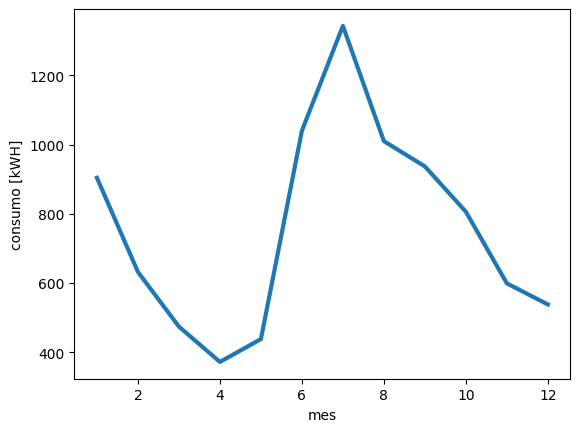

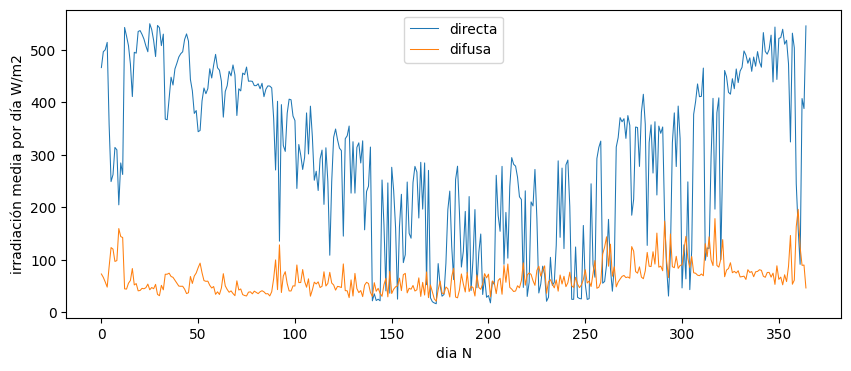

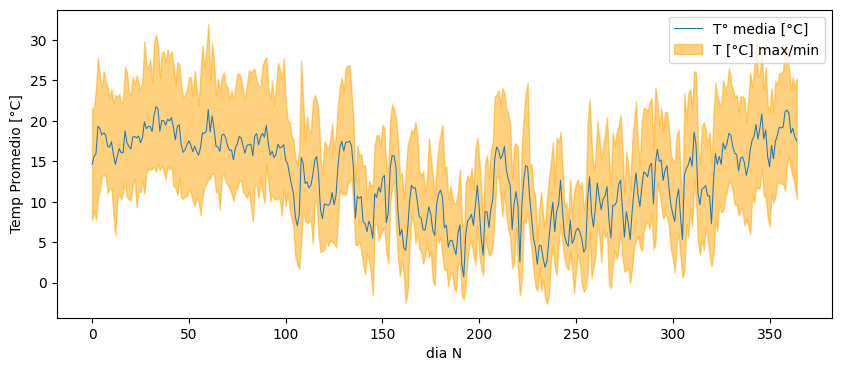

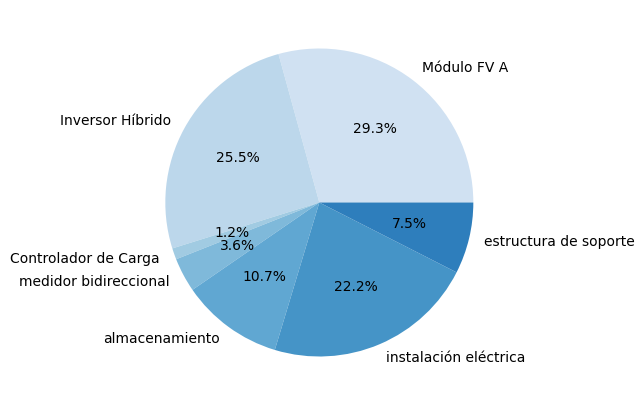

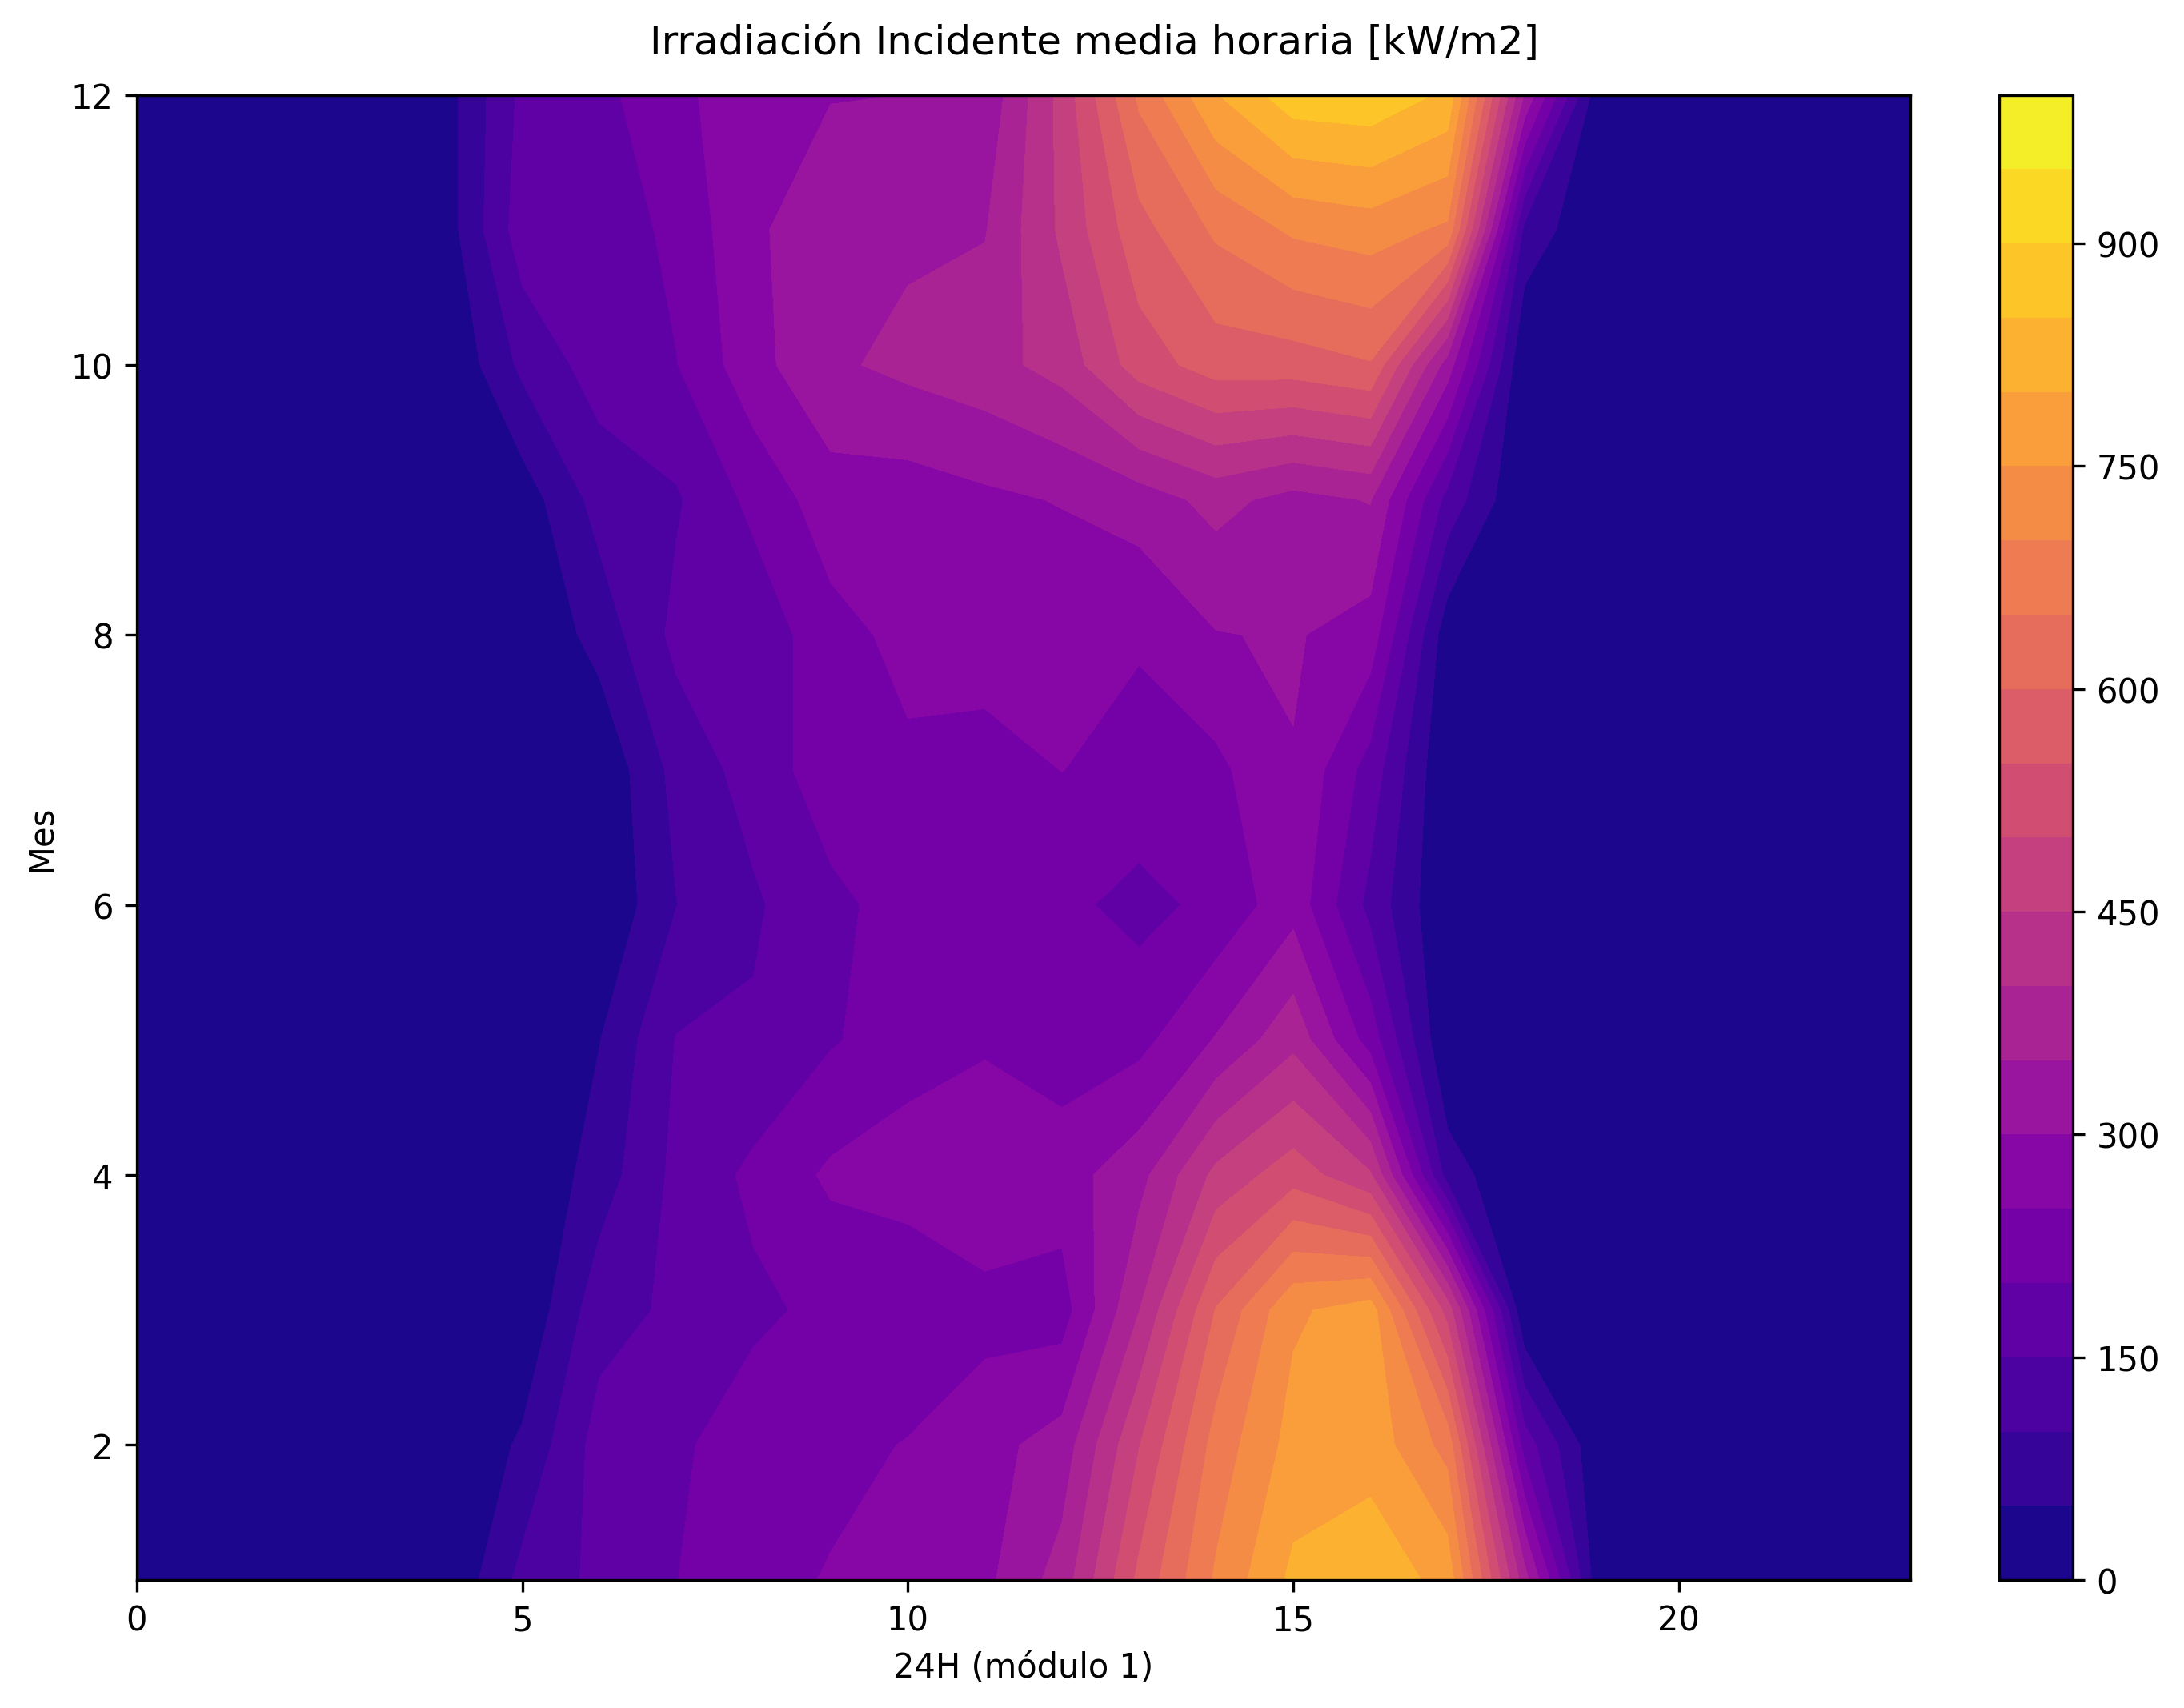

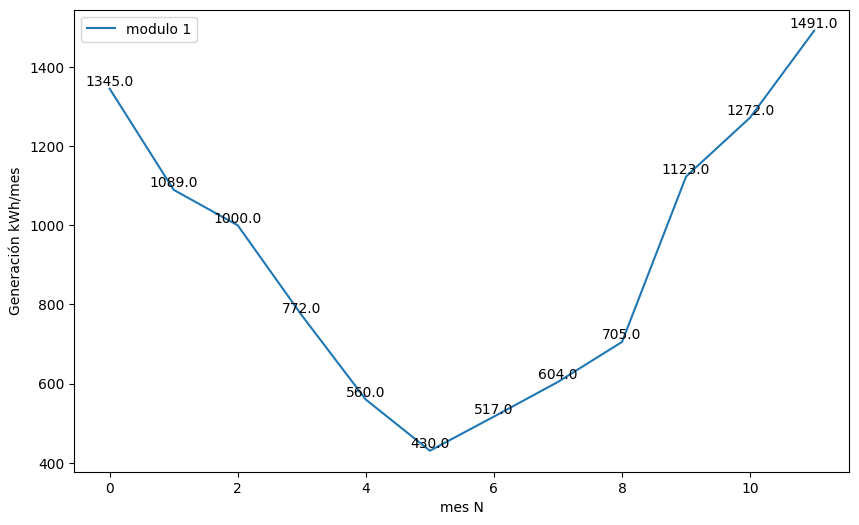

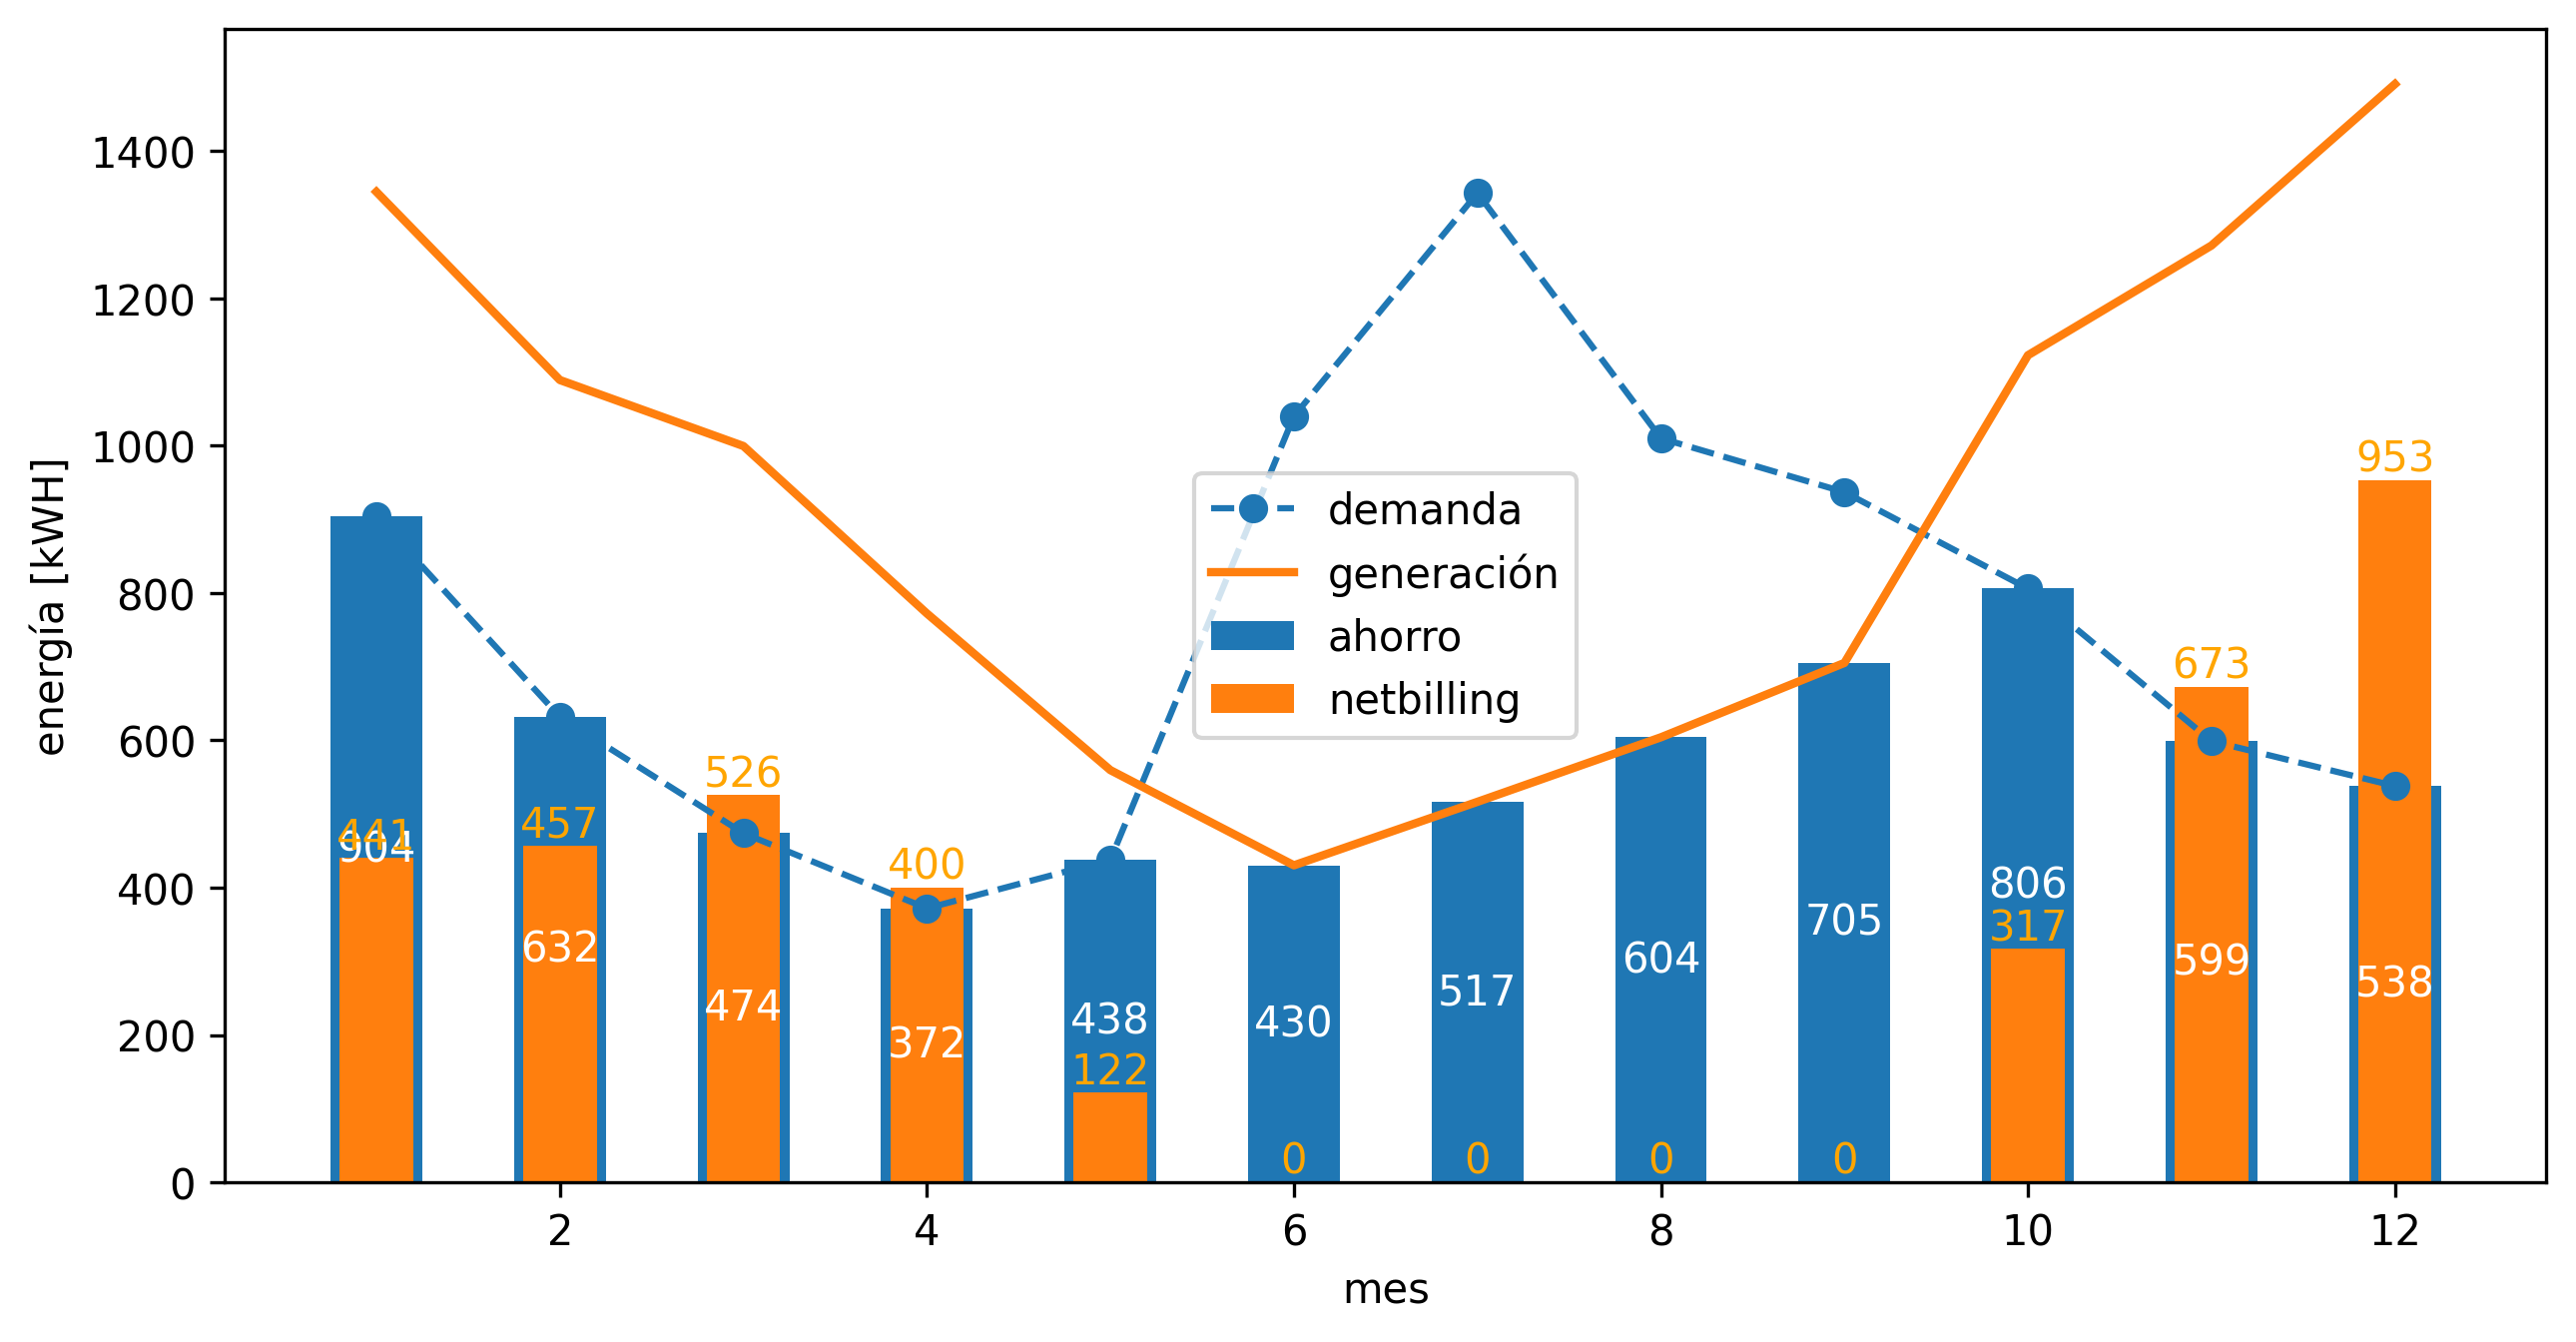

<Figure size 1920x1440 with 0 Axes>

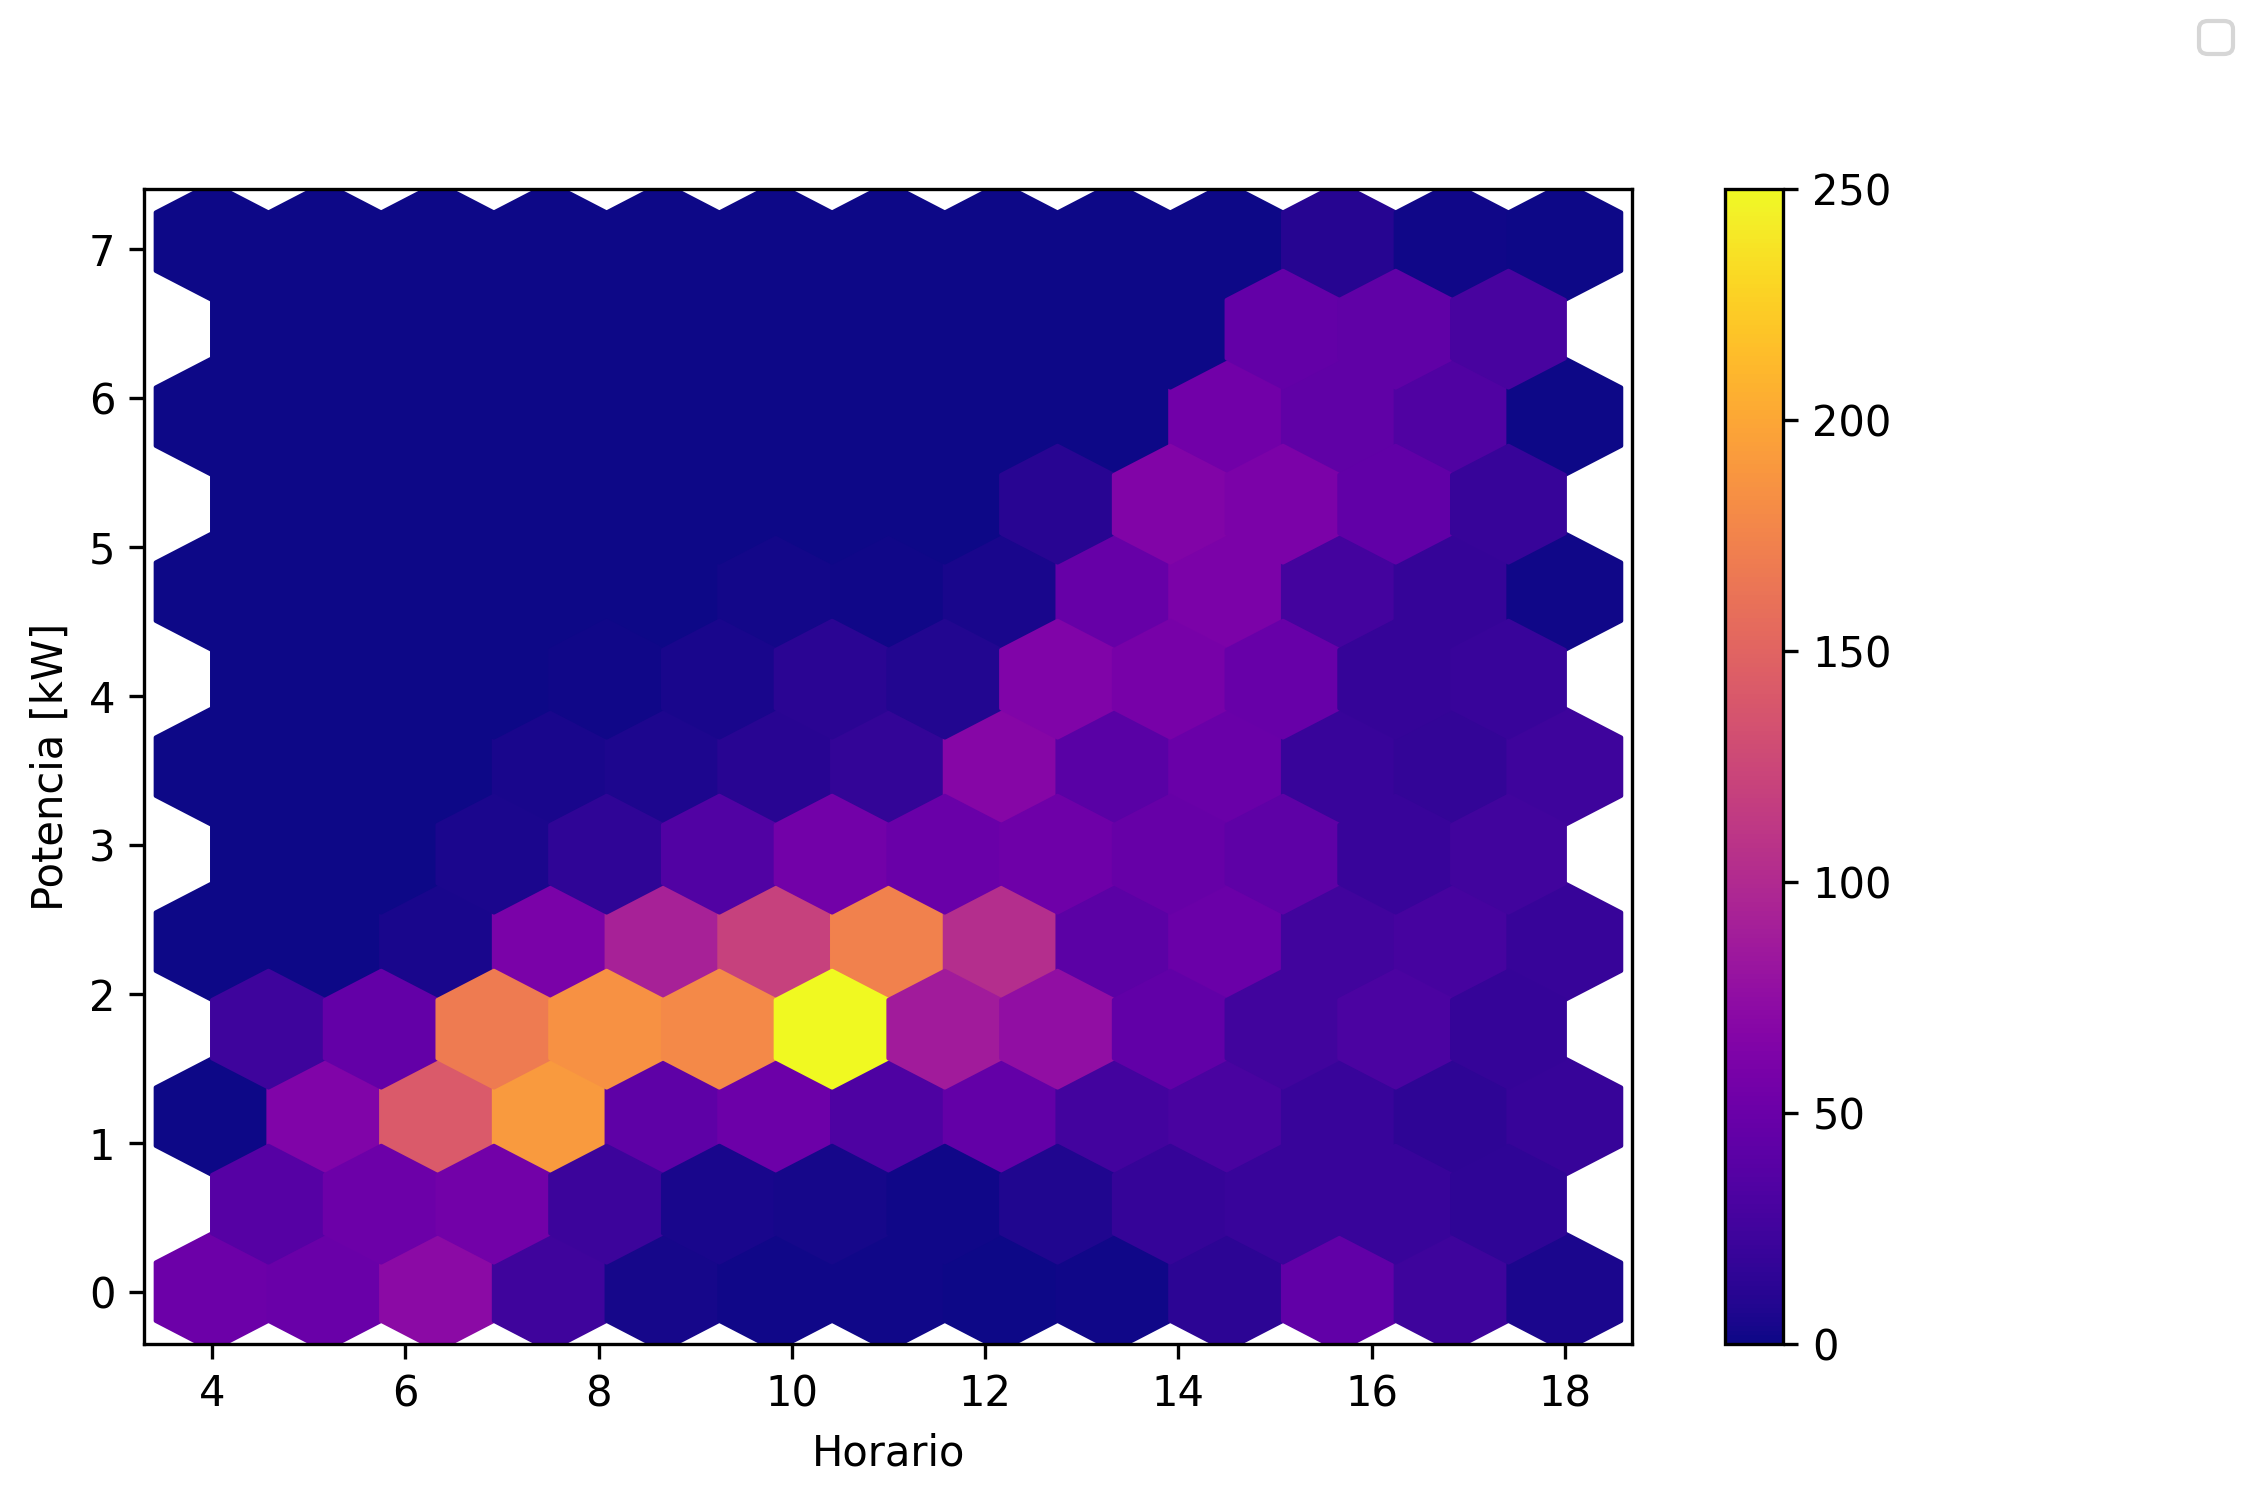

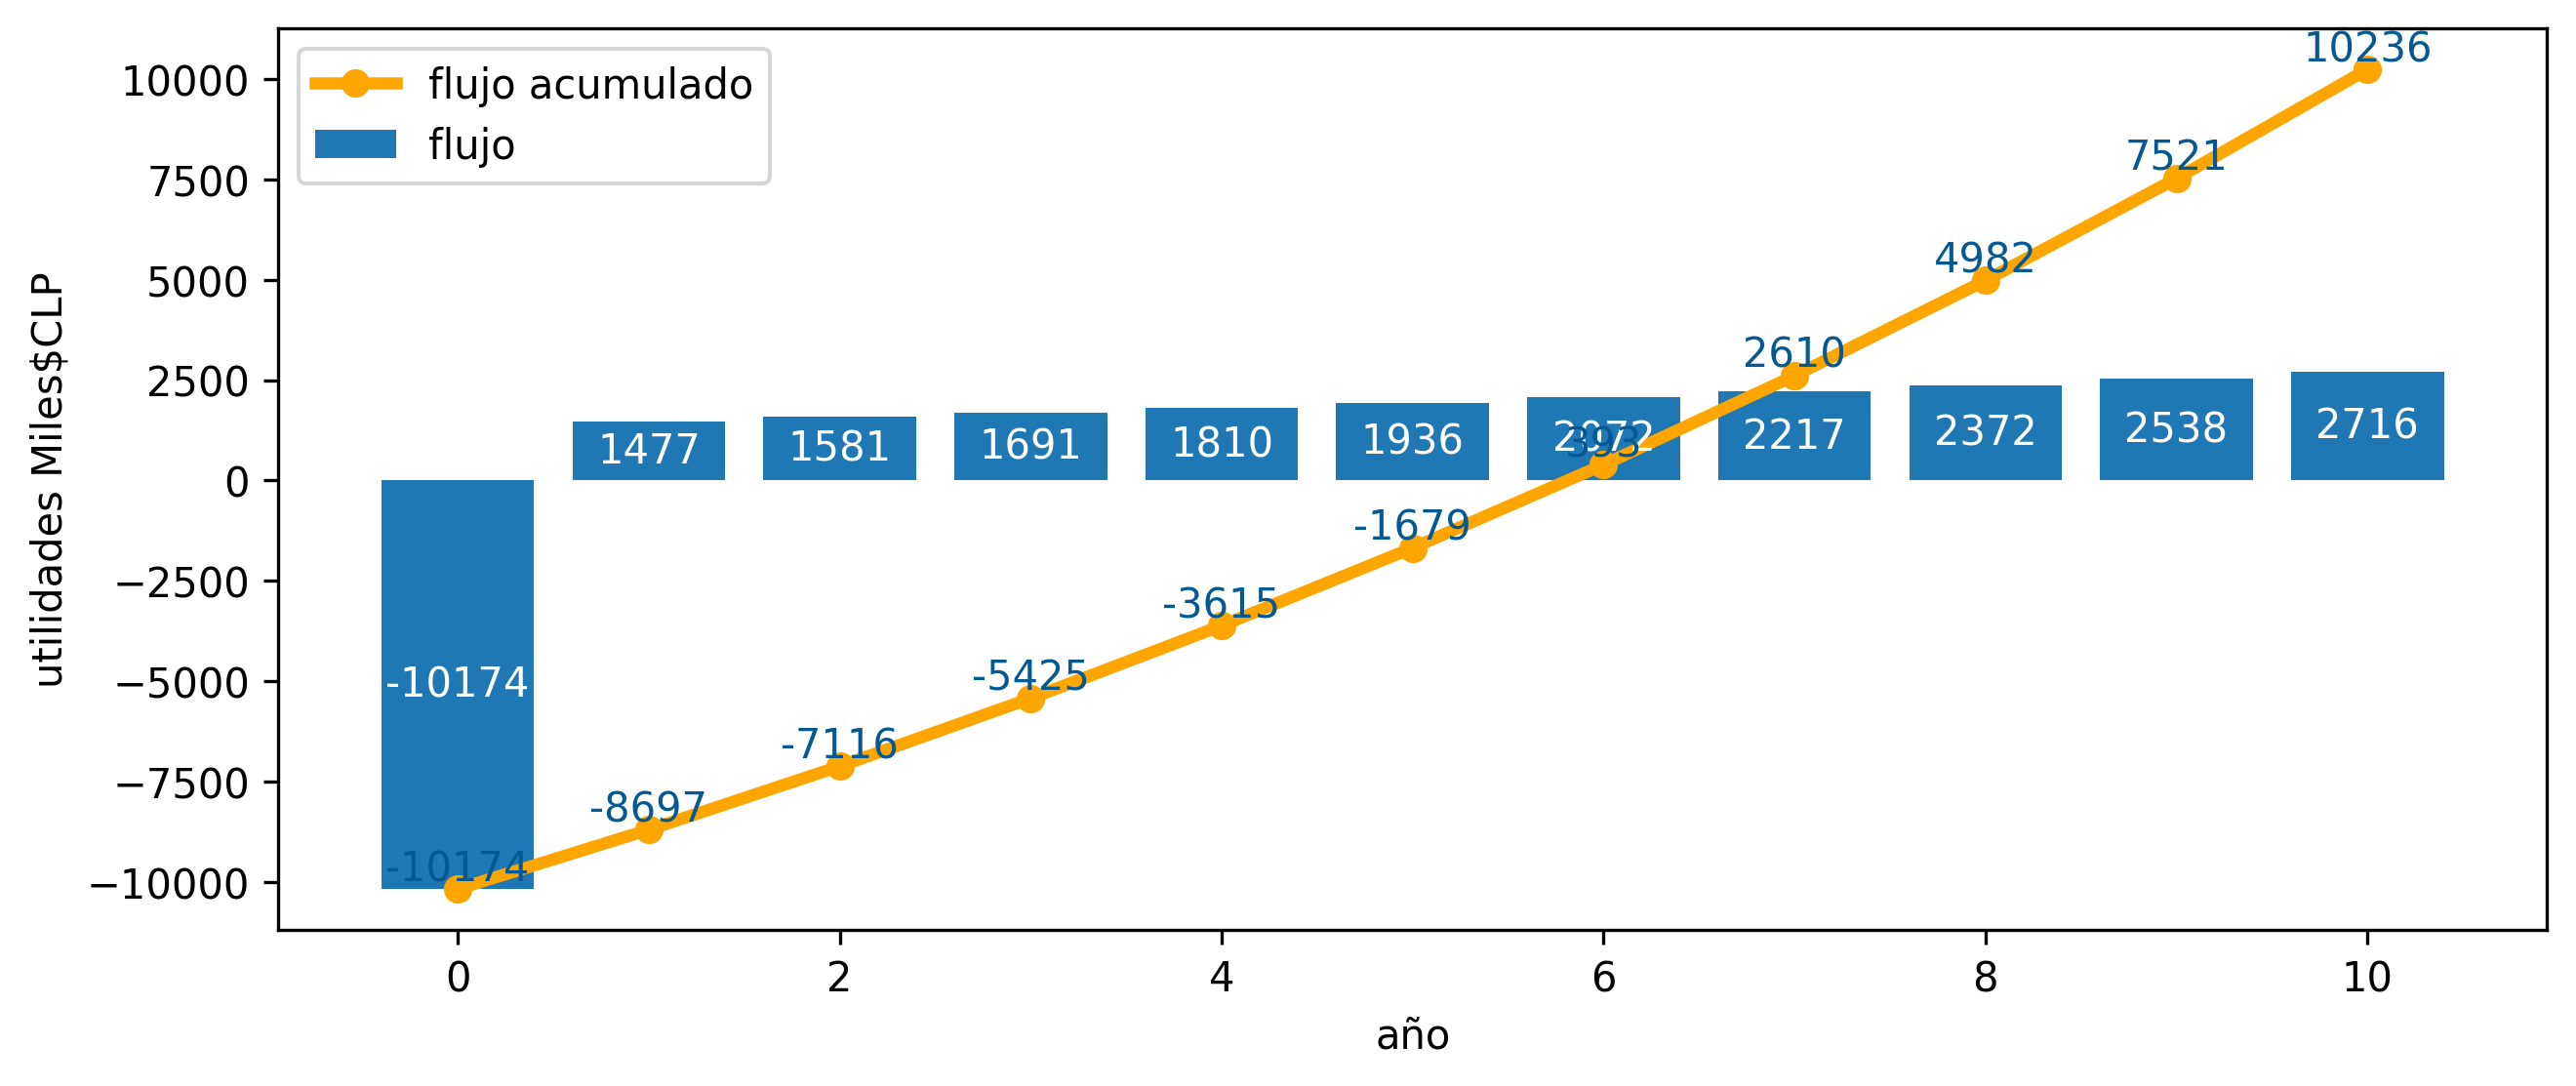

In [10]:
#dep
from models.plotter import plotter
plotter(project,PATH)

In [11]:
#set into doc
plot_list = [
    'plot_consumption_forecast',
    'plot_irradiance',
    'plot_temperature',
    'plot_components',
    'plot_components_irr',
    'plot_components_production',
    'plot_production_performance',
    'plot_performance_frequency',
    'plot_flux',
]

for plot in plot_list:
    memory_report.replace_pic(plot,PATH+f'{plot}.png')
    print('replaced plot:',plot)

replaced plot: plot_consumption_forecast
replaced plot: plot_irradiance
replaced plot: plot_temperature
replaced plot: plot_components
replaced plot: plot_components_irr
replaced plot: plot_components_production
replaced plot: plot_production_performance
replaced plot: plot_performance_frequency
replaced plot: plot_flux


In [12]:
memory_report.save(PATH+f"reporte_memoria_calculo.docx")
bidding_report.save(PATH+f"reporte_pliegos_técnicos.docx")